# Model6
Preprocessing: 3DS

Machine Learning model: SVM, RR, GTB, RF

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import glob
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import namedtuple
from sklearn import metrics
from sklearn.model_selection import KFold, learning_curve
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew, kurtosis

In [ ]:
# @title Original function
def pooling(df,spl = 10):
  ind = np.arange(int(df.shape[0]/spl))*spl
  pool_val = [];ind_ = []
  for i in range(len(ind[:-1])):
    pool_val.append(df.values[ind[i]:ind[i+1]].mean(0))
    ind_.append(np.mean(df.index[ind[i]:ind[i+1]]))
  pool_val.append(df.values[ind[-1]:].mean(0))
  ind_.append(np.mean(df.index[ind[-1]:]))
  return pd.DataFrame(np.array(pool_val), columns=df.columns, index=ind_)

def train_(X, y, model, cv=10, label='aBMD $[g/cm^2]$'):
  res_pred = np.zeros_like(y);r2_add=[]
  cv = KFold(n_splits=cv, shuffle=True, random_state=1234)
  for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = model.fit(X_train,y_train)
    pred = model.predict(X_test)
    res_pred[test_index] = pred
    print('r2 = ', metrics.r2_score(y_test,pred))
    r2_add.append(metrics.r2_score(y_test,pred))
  print('All r2 = ', metrics.r2_score(y,res_pred))
  print('Mean r2 = ', round(np.mean(r2_add),5),'±', round(np.std(r2_add),5))
  showGraph(y,res_pred,label = label,dpi=100)
  return res_pred, metrics.r2_score(y,res_pred)

def showGraph(y,res_pred,label = 'aBMD $[g/cm^2]$',dpi=100,figsize =(4,4)):
  plt.figure(figsize=figsize,dpi=dpi)
  plt.plot(y,res_pred,'.' ,c = 'k')
  correlationLine(y,res_pred,score = 'r2')
  plt.legend(edgecolor='none')
  plt.xlabel('Reference '+label)
  plt.ylabel('Predicted '+label)
  plt.show()
  plt.figure(figsize=figsize,dpi=dpi)
  plt.plot((y+res_pred)/2,y-res_pred,'.' ,c = 'k')
  max_ = max((y+res_pred)/2)
  min_ = min((y+res_pred)/2)
  mean_ = np.mean(y-res_pred)
  upp_ = mean_+1.96*np.std(y-res_pred)
  low_ = mean_-1.96*np.std(y-res_pred)
  plt.plot([min_,max_],[mean_,mean_],':',c = 'k')
  plt.plot([min_,max_],[upp_,upp_],'-.',c = 'k')
  plt.plot([min_,max_],[low_,low_],'-.',c = 'k')
  correlationLine((y+res_pred)/2,y-res_pred)
  plt.legend(edgecolor='none')
  label_ = 'Mean of predicted and reference '+label
  plt.xlabel(label_)
  label_ = 'Difference between \n predicted and reference '+label
  plt.ylabel(label_)
  plt.show()
  print('loa_upper: ',round(upp_,5))
  print('loa_lower: ',round(low_,5))
  print("Mean: ",mean_)

def correlationLine(x,y,score = 'r'):
  x = np.array(x).flatten()
  y = np.array(y).flatten()
  #相関
  if score =='r':
    slope, intercept, r_value, _, _ = stats.linregress(x,y)
    r, p = stats.pearsonr(x,y)
    print(stats.spearmanr(x,y))
    label_ = "r = "+str(round(r_value,3))
  if score == 'r2':
    r_value = metrics.r2_score(x,y)
    label_ = "$r^2$ = "+str(round(r_value,3))
    print('pearsonr:',stats.pearsonr(x,y))
  ysub = np.poly1d(np.polyfit(x,y,1))(x)
  xx = [x.min(),x.max()]
  yy = [ysub.min(),ysub.max()]
  if r_value < 0:
    yy = [ysub.max(),ysub.min()]
  plt.plot(xx,yy,"--",color="0.2",label = label_)

def plot_learning_curve(X, y, model, cv=10):
  train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                          X=X, y=y, scoring='r2',
                                                          cv=cv, n_jobs=-1)
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)
  plt.figure()
  plt.plot(train_sizes, train_mean, marker='o', label='Train score')
  plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.2)
  plt.plot(train_sizes, test_mean, marker='s', linestyle='--', label='Validation score')
  plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.2)
  plt.grid()
  plt.xlabel('Number of samples in training set')
  plt.ylabel('$r^2$')
  plt.legend()
  plt.show()

In [ ]:
version = "3ds"
path = f"/content/drive/MyDrive/Tamura/ML/{version}/dataset/"

nn = 1211
B_files = sorted(glob.glob(f"{path}opt_result/*B.csv"))[:nn]
F_files = sorted(glob.glob(f"{path}opt_result/*F.csv"))[:nn]
L_files = sorted(glob.glob(f"{path}opt_result/*L.csv"))[:nn]
sim_params = pd.read_csv(f"{path}params.csv", index_col=1).sort_index(axis='index').iloc[:nn]

B ={}; F = {};L = {}
for B_file, F_file, L_file in tqdm(zip(B_files, F_files, L_files)):
  df_B = pd.read_csv(B_file, index_col=0)
  df_F = pd.read_csv(F_file, index_col=0)
  df_L = pd.read_csv(L_file, index_col=0)
  B[df_B.columns[0]] = df_B.iloc[:, 0]
  F[df_F.columns[0]] = df_F.iloc[:, 0]
  L[df_L.columns[0]] = df_L.iloc[:, 0]
B = pd.DataFrame(B, index=df_B.index)
F = pd.DataFrame(F, index=df_F.index)
L = pd.DataFrame(L, index=df_L.index)

1211it [03:20,  6.03it/s]


In [ ]:
for b, f, l, sim in zip(B.columns, F.columns, L.columns, sim_params.index):
  bf, ff, lf = b.split('_B')[0], f.split('_F')[0], l.split('_L')[0]
  assert bf == ff == lf == sim

In [ ]:
nroll = 10
L_roll = L.rolling(nroll, center=True).mean()
L_roll = L_roll.dropna(axis=0)

In [ ]:
L_roll_pool = pooling(L_roll, spl=20)
B_pool = pooling(B, spl=4)
F_pool = pooling(F, spl=4)

In [ ]:
dataset = pd.DataFrame(np.concatenate([(B_pool.T.values), np.log(L_roll_pool.T.values)], axis=1))

In [ ]:
dataset['B_mean'] = np.log(B_pool.values).mean(0)
dataset['B_var'] = np.log(B_pool.values).var(0)

dataset['F_mean'] = np.log(F_pool.values).mean(0)
dataset['F_var'] = np.log(F_pool.values).var(0)

dataset['L_mean'] = np.log(L_roll_pool.values).mean(0)
dataset['L_var'] = np.log(L_roll_pool.values).var(0)

In [ ]:
dataset['target'] = sim_params.aBMD.values
features = dataset.drop('target', axis=1).columns

In [ ]:
X = dataset[features].values
X = (X - X.mean(0)) / X.std(0)
y = dataset.target.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [ ]:
# @title Random Forest
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("RF",
        RandomForestRegressor(),
      {"n_estimators": [10, 20, 50, 100, 300],
       "max_features": ["log2", "sqrt", 1.0],
       "max_depth": [10, 20, 30, 40, 50],
       "n_jobs": [-1],
       })

In [ ]:
# @title Gradient Tree Boosting
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("GTB",
        GradientBoostingRegressor(),
        {"n_estimators": [10, 20, 50, 100, 300],
         "max_features": ["log2", "sqrt", 1.0],
         "max_depth": [1, 2, 3, 4, 5],
         "learning_rate": [0.001, 0.01, 0.1, 1.0, 10],
         })

In [ ]:
# @title Support Vector Machine
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("SVM",
        SVR(),
       {"kernel": ["rbf"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],
        })

In [ ]:
# @title Ridge Regressor
ml = namedtuple("ml", ["name", "model", "params"])
ml = ml("RR",
        Ridge(),
       {"alpha": [0.001, 0.01, 0.1, 1.0, 10],
        "fit_intercept": [True, False]
        })

In [ ]:
grid_search = GridSearchCV(ml.model, ml.params, cv=10, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)
print(f"Model: {ml.model}")
print(f"Best params: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")
print(f"Test score: {grid_search.score(X_test, y_test)}")

Model: RandomForestRegressor()
Best params: {'max_depth': 20, 'max_features': 1.0, 'n_estimators': 300, 'n_jobs': -1}
Best score: 0.09528646868266982
Test score: 0.15949887555752884


In [ ]:
result = {}

r2 =  0.16399628226723717
r2 =  0.23982978304218627
r2 =  0.09587676495115127
r2 =  0.11891406409436445
r2 =  0.10190800319456594
r2 =  0.0871618661596324
r2 =  0.15841634080890055
r2 =  0.11813439947911086
r2 =  0.149475617256272
r2 =  0.08677052430397392
All r2 =  0.1388235314373334
Mean r2 =  0.13205 ± 0.04504
pearsonr: PearsonRResult(statistic=0.37611793270308397, pvalue=5.495016785687353e-42)


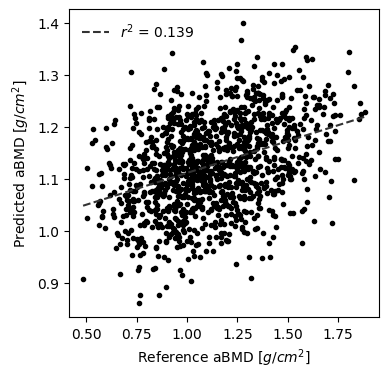

SignificanceResult(statistic=0.8275230645953267, pvalue=2.201409524344364e-305)


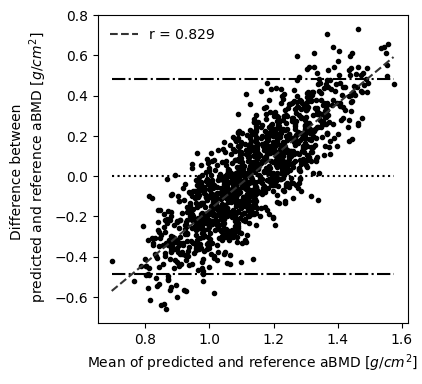

loa_upper:  0.48328
loa_lower:  -0.48751
Mean:  -0.002115655881985556


In [ ]:
ml.model.set_params(**grid_search.best_params_)
pred_, r2 = train_(X, y, ml.model, cv=10, label="aBMD $[g/cm^2]$")
result[ml.name] = r2

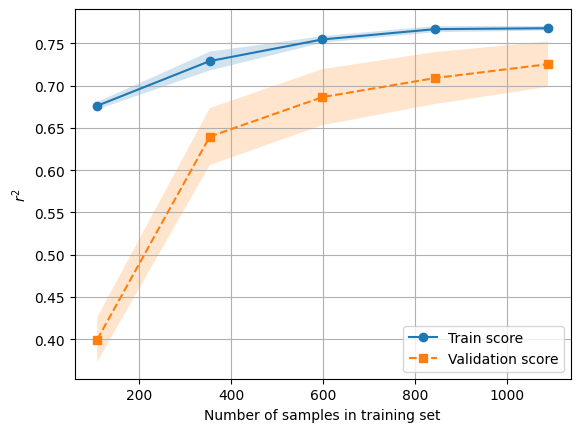

In [ ]:
plot_learning_curve(X, y, ml.model)

In [ ]:
df = pd.DataFrame(result, index=['r2'])
df

In [ ]:
path = f"/content/drive/MyDrive/Tamura/ML/{version}/result/"

f_num = len(glob.glob(f"{path}*.csv"))
df.to_csv(f"{path}result{f_num + 1}.csv")